In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


In [3]:
DATA_PATH = "/kaggle/input/merged-dataset/final_financial_causality_dataset.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,date,ticker,title,clean_text,return_t1,return_t5,volatility_5,causal_label
0,2018-01-24,IRS,Trump to name tax lawyer Rettig to head IRS - ...,"January 24, 2018 / 2:55 AM / Updated 12 minute...",-0.058179,-0.014003,0.038975,1
1,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
2,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
3,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
4,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1


BASIC SANITY CHECK (IMPORTANT)

In [4]:
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("\nLabel distribution:")
print(df["causal_label"].value_counts(normalize=True))


Rows: 36672
Columns: ['date', 'ticker', 'title', 'clean_text', 'return_t1', 'return_t5', 'volatility_5', 'causal_label']

Label distribution:
causal_label
1    0.765407
0    0.234593
Name: proportion, dtype: float64


TRAIN / TEST SPLIT (TIME-AWARE)

In [5]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

split_date = df["date"].quantile(0.8)

train_df = df[df["date"] <= split_date]
test_df  = df[df["date"] > split_date]

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 29442
Test size: 7230


DEFINE FEATURES & LABEL

In [6]:
X_train_text = train_df["clean_text"]
X_test_text  = test_df["clean_text"]

y_train = train_df["causal_label"]
y_test  = test_df["causal_label"]


TEXT-ONLY BASELINE MODEL (REQUIRED)

In [7]:
text_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])


TRAIN THE MODEL

In [8]:
text_model.fit(X_train_text, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

EVALUATION (PAPER-READY)

In [9]:
y_pred = text_model.predict(X_test_text)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.5663900414937759
Precision: 0.6698627561571724
Recall   : 0.7209631728045326
F1 Score : 0.6944742227853036

Classification Report:

              precision    recall  f1-score   support

           0       0.28      0.23      0.25      2288
           1       0.67      0.72      0.69      4942

    accuracy                           0.57      7230
   macro avg       0.47      0.48      0.47      7230
weighted avg       0.55      0.57      0.55      7230



ADD NUMERICAL FEATURES (MULTIMODAL BASELINE)
🔹 Combine text + numerical signals

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [11]:
X_train = train_df[
    ["clean_text", "return_t1", "return_t5", "volatility_5"]
]
X_test = test_df[
    ["clean_text", "return_t1", "return_t5", "volatility_5"]
]


MULTIMODAL PIPELINE

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            stop_words="english"
        ), "clean_text"),
        
        ("num", StandardScaler(),
         ["return_t1", "return_t5", "volatility_5"])
    ]
)


In [13]:
multimodal_model = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])


tRAIN MULTIMODAL MODEL

In [14]:
multimodal_model.fit(X_train, y_train)


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=20000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['return_t1', 'return_t5',
                                                   'volatility_5'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

EVALUATE MULTIMODAL MODEL

In [15]:
y_pred_mm = multimodal_model.predict(X_test)

print("MULTIMODAL RESULTS")
print("Accuracy :", accuracy_score(y_test, y_pred_mm))
print("Precision:", precision_score(y_test, y_pred_mm))
print("Recall   :", recall_score(y_test, y_pred_mm))
print("F1 Score :", f1_score(y_test, y_pred_mm))

MULTIMODAL RESULTS
Accuracy : 0.7719225449515906
Precision: 0.9121401752190238
Recall   : 0.7373532982598139
F1 Score : 0.8154861810450936


In [16]:
import joblib

joblib.dump(text_model, "/kaggle/working/text_only_model.pkl")
joblib.dump(multimodal_model, "/kaggle/working/multimodal_model.pkl")


['/kaggle/working/multimodal_model.pkl']

In [17]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


In [19]:
df = pd.read_csv(
    "/kaggle/input/merged-dataset/final_financial_causality_dataset.csv"
)

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

split_date = df["date"].quantile(0.8)

train_df = df[df["date"] <= split_date]
test_df  = df[df["date"] > split_date]

X_train_text = train_df["clean_text"]
X_test_text  = test_df["clean_text"]

X_train_num = train_df[["return_t1","return_t5","volatility_5"]]
X_test_num  = test_df[["return_t1","return_t5","volatility_5"]]

y_train = train_df["causal_label"]
y_test  = test_df["causal_label"]


MODEL 1 — TF-IDF + LOGISTIC REGRESSION (TEXT ONLY)

In [20]:
model_lr_text = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

model_lr_text.fit(X_train_text, y_train)

y_pred = model_lr_text.predict(X_test_text)

print("TEXT LR F1:", f1_score(y_test, y_pred))


TEXT LR F1: 0.6944742227853036


MODEL 2 — TF-IDF + LINEAR SVM (TEXT ONLY)

In [21]:
model_svm_text = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

model_svm_text.fit(X_train_text, y_train)

y_pred = model_svm_text.predict(X_test_text)

print("TEXT SVM F1:", f1_score(y_test, y_pred))


TEXT SVM F1: 0.7098730339207884


MODEL 3 — TF-IDF + NAIVE BAYES (TEXT ONLY)

In [22]:
model_nb_text = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        stop_words="english"
    )),
    ("clf", MultinomialNB())
])

model_nb_text.fit(X_train_text, y_train)

y_pred = model_nb_text.predict(X_test_text)

print("TEXT NB F1:", f1_score(y_test, y_pred))


TEXT NB F1: 0.5164075993091537


MODEL 4 — LOGISTIC REGRESSION (NUMERICAL ONLY)

In [23]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled  = scaler.transform(X_test_num)

model_lr_num = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model_lr_num.fit(X_train_scaled, y_train)

y_pred = model_lr_num.predict(X_test_scaled)

print("NUMERIC LR F1:", f1_score(y_test, y_pred))


NUMERIC LR F1: 0.8074405787116776


MODEL 5 — MULTIMODAL (TF-IDF + NUM) + LOGISTIC REGRESSION ⭐

In [24]:
preprocessor = ColumnTransformer([
    ("text", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    ), "clean_text"),
    
    ("num", StandardScaler(),
     ["return_t1","return_t5","volatility_5"])
])

model_lr_mm = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

model_lr_mm.fit(train_df, y_train)

y_pred = model_lr_mm.predict(test_df)

print("MULTIMODAL LR F1:", f1_score(y_test, y_pred))


MULTIMODAL LR F1: 0.8154861810450936


MODEL 6 — MULTIMODAL (TF-IDF + NUM) + LINEAR SVM ⭐

In [25]:
model_svm_mm = Pipeline([
    ("features", preprocessor),
    ("clf", LinearSVC(class_weight="balanced"))
])

model_svm_mm.fit(train_df, y_train)

y_pred = model_svm_mm.predict(test_df)

print("MULTIMODAL SVM F1:", f1_score(y_test, y_pred))


MULTIMODAL SVM F1: 0.8103779628443306


COLLECT RESULTS CLEANLY

In [26]:
results = []

def eval_model(name, y_true, y_pred):
    results.append({
        "Model": name,
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    })

# Example
eval_model("Text LR", y_test, model_lr_text.predict(X_test_text))
eval_model("Text SVM", y_test, model_svm_text.predict(X_test_text))
eval_model("Numeric LR", y_test, model_lr_num.predict(X_test_scaled))
eval_model("Multimodal LR", y_test, model_lr_mm.predict(test_df))
eval_model("Multimodal SVM", y_test, model_svm_mm.predict(test_df))

pd.DataFrame(results)


,Model,Precision,Recall,F1
0,Text LR,0.669863,0.720963,0.694474
1,Text SVM,0.667498,0.757993,0.709873
2,Numeric LR,0.933369,0.711453,0.807441
3,Multimodal LR,0.912140,0.737353,0.815486
4,Multimodal SVM,0.857821,0.767908,0.810378


In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc
)


CONFUSION MATRIX PLOT

In [29]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center")

    plt.tight_layout()
    plt.show()


ROC CURVE PLOT

In [30]:
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

model_text_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

model_text_lr.fit(X_train_text, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

TEXT-ONLY LOGISTIC REGRESSION

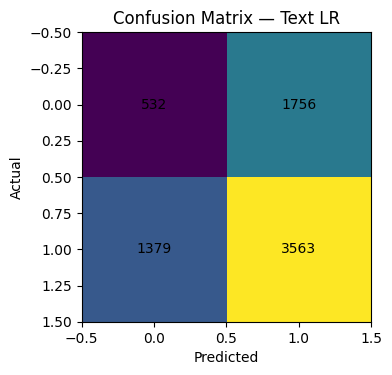

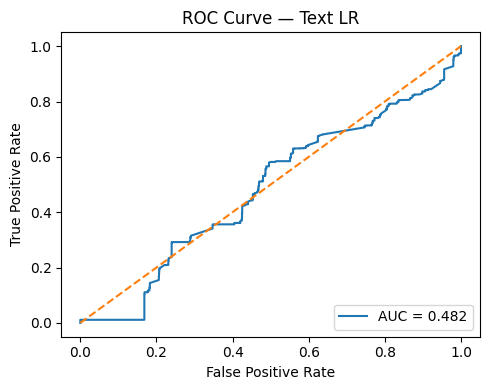

In [33]:
# Predictions
y_pred = model_text_lr.predict(X_test_text)
y_prob = model_text_lr.predict_proba(X_test_text)[:, 1]

plot_confusion_matrix(
    y_test, y_pred,
    "Confusion Matrix — Text LR"
)

plot_roc_curve(
    y_test, y_prob,
    "ROC Curve — Text LR"
)


MULTIMODAL LOGISTIC REGRESSION

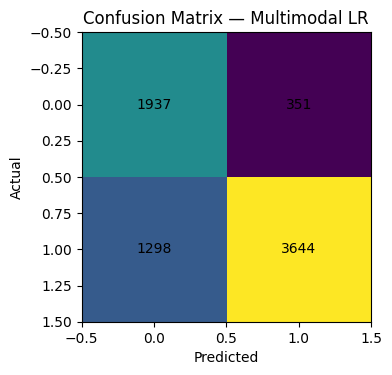

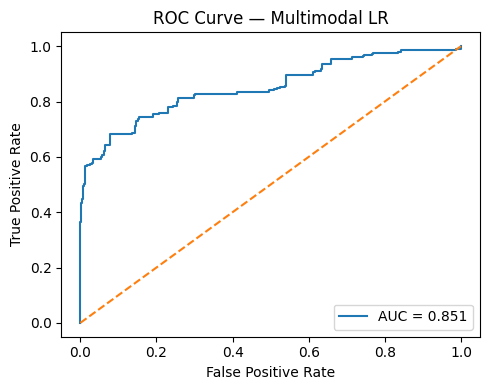

In [34]:
y_pred_mm = model_lr_mm.predict(test_df)
y_prob_mm = model_lr_mm.predict_proba(test_df)[:, 1]

plot_confusion_matrix(
    y_test, y_pred_mm,
    "Confusion Matrix — Multimodal LR"
)

plot_roc_curve(
    y_test, y_prob_mm,
    "ROC Curve — Multimodal LR"
)


tEXT-ONLY SVM (CONFUSION MATRIX ONLY)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

model_text_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

model_text_svm.fit(X_train_text, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LinearSVC(class_weight='balanced'))])

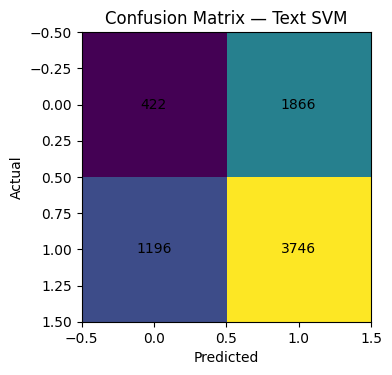

In [37]:
y_pred_svm = model_text_svm.predict(X_test_text)

plot_confusion_matrix(
    y_test, y_pred_svm,
    "Confusion Matrix — Text SVM"
)


FINAL COMPARISON BAR CHART

In [38]:
models = ["Text LR", "Text SVM", "Multimodal LR", "Multimodal SVM"]
f1_scores = [
    f1_score(y_test, model_text_lr.predict(X_test_text)),
    f1_score(y_test, model_text_svm.predict(X_test_text)),
    f1_score(y_test, model_lr_mm.predict(test_df)),
    f1_score(y_test, model_svm_mm.predict(test_df))
]


STEP 2 — Plot

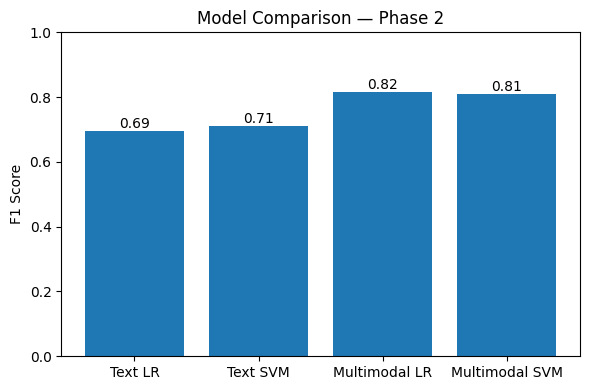

In [39]:
plt.figure(figsize=(6, 4))
plt.bar(models, f1_scores)

plt.ylabel("F1 Score")
plt.title("Model Comparison — Phase 2")
plt.ylim(0, 1)

for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.show()
